### 1. Introduction

Can one predict when an engine or device breaks down?

This seems a pure engineering question. But nowadays it is also a data science question. 
More concretely, it is an important question everywhere engines and devices use data to guide maintenance, such as aircraft engines, windturbine engines, and rotating machinery. With regards to human safety and logistic planning, it is not a good idea to just wait until an engine breaks down. It is essential to *proactively* plan maintenance to avoid costly downtime. 

Proactive planning is enabled by *multiple sensor technologies* that provide powerful data about the state of machines and devices. Sensors include data such as temperature, fan and core speed, static pressure etc. Can we use these data to predict within certain margins how long an aircraft engine will be functioning without failure? And if so, how to do it?

This is the question the concept of *remaining useful life (RUL)* attempts to answer. It aims to estimate *the remaining time an item, component, or system is able to function in accordance with its intended purpose before warranting replacement*. The present blog shows how to use machine learning in Gradient Boosting Regression to predict the RUL. It is meant to provide an example case study, not an exhaustive and ultimate solution. 

### 2. Modules

The following modules will be used:

In [1]:
import os
import pandas as pd
import numpy as np
np.random.seed(1337)
from IPython.display import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

The following settings will be used to avoid exponential values in output or tables and to display 50 rows maximum:

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows=50

### 3. Sketch of the question

A simplified lineplot illustrates best the question at hand. Given a fictive temperature sensor, for which we have 8 cycles, are we able to predict the remaining cycles? 

The kind of questions that can be addressed for such a time-serie: 
* Can we forecast the temperature of the future time-points?
* Can we predict how long the time-serie continues until a pre-defined event happens?

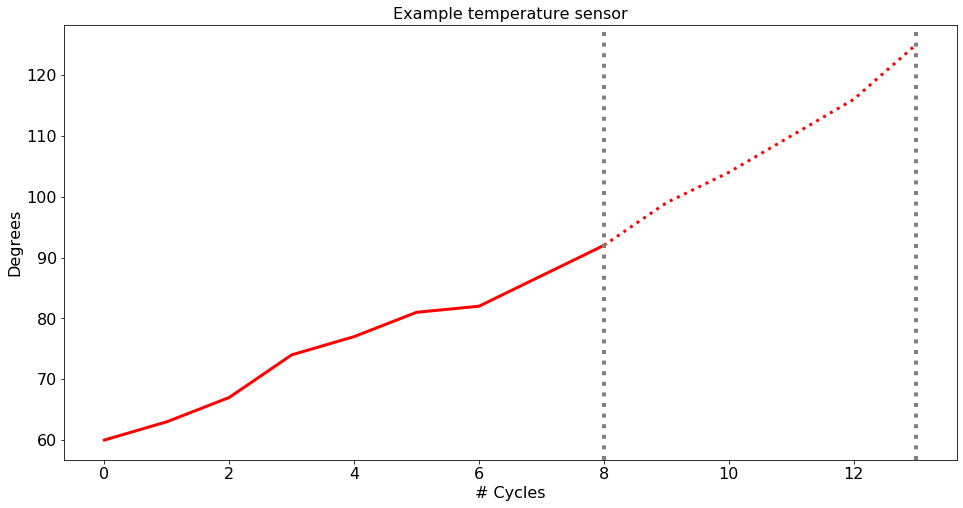

In [3]:
A=[60,63,67,74,77,81,82,87,92]
B=[92,99,104,110,116,125]
C = np.append(np.repeat(np.nan, len(A)-1), B)
plt.figure(figsize = (16, 8))
plt.plot(A, color='red', linewidth=3)
plt.plot(C, 'r:', linewidth=3)
plt.axvline(x=len(A)-1, color='grey', linestyle=':', linewidth=4)
plt.axvline(x=len(C)-1, color='grey', linestyle=':', linewidth=4)
plt.title('Example temperature sensor', fontsize=16)
plt.xlabel('# Cycles', fontsize=16)
plt.ylabel('Degrees', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

### 4. Loading the data

Now that the files are in your home directory, you can read them using Pandas **read_csv**. We will load a train- and testset, as well as a RUL set. RUL contains the true values for remaining useful life to which we are going to compare our predicted values in the testset.

In [4]:
train = pd.read_csv('Train_set.csv')
test = pd.read_csv('Test_set.csv')
RUL = pd.read_csv('RUL_set.csv', header=None)

### 5. Missing values

First, we need to drop the two last columns since they actually only have missing values. This is probably due to trailing tab characters in the csv file. At any time, it is always better to verify this as the owners of the data may have edited this at any moment. The following code prints the proportion of missing values for each column in the train- and testset:

In [5]:
tableNA = pd.concat([train.isnull().sum(), test.isnull().sum()], axis=1)
tableNA.columns = ['train', 'test']
tableNA

,train,test
unit,0,0
cycles,0,0
op_setting1,0,0
op_setting2,0,0
op_setting3,0,0
s1,0,0
s2,0,0
s3,0,0
s4,0,0
s5,0,0


And so the train- and testset look as follows:

In [6]:
train.head()

,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.001,-0.000,100,518.670,641.820,1589.700,1400.600,14.620,...,521.660,2388.020,8138.620,8.419,0.030,392,2388,100,39.060,23.419
1,1,2,0.002,-0.000,100,518.670,642.150,1591.820,1403.140,14.620,...,522.280,2388.070,8131.490,8.432,0.030,392,2388,100,39.000,23.424
2,1,3,-0.004,0.000,100,518.670,642.350,1587.990,1404.200,14.620,...,522.420,2388.030,8133.230,8.418,0.030,390,2388,100,38.950,23.344
3,1,4,0.001,0.000,100,518.670,642.350,1582.790,1401.870,14.620,...,522.860,2388.080,8133.830,8.368,0.030,392,2388,100,38.880,23.374
4,1,5,-0.002,-0.000,100,518.670,642.370,1582.850,1406.220,14.620,...,522.190,2388.040,8133.800,8.429,0.030,393,2388,100,38.900,23.404


In [7]:
test.head()

,unit,cycles,op_setting1,op_setting2,op_setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.002,0.000,100,518.670,643.020,1585.290,1398.210,14.620,...,521.720,2388.030,8125.550,8.405,0.030,392,2388,100,38.860,23.373
1,1,2,-0.003,-0.000,100,518.670,641.710,1588.450,1395.420,14.620,...,522.160,2388.060,8139.620,8.380,0.030,393,2388,100,39.020,23.392
2,1,3,0.000,0.000,100,518.670,642.460,1586.940,1401.340,14.620,...,521.970,2388.030,8130.100,8.444,0.030,393,2388,100,39.080,23.417
3,1,4,0.004,0.000,100,518.670,642.440,1584.120,1406.420,14.620,...,521.380,2388.050,8132.900,8.392,0.030,391,2388,100,39.000,23.374
4,1,5,0.001,0.000,100,518.670,642.510,1587.190,1401.920,14.620,...,522.150,2388.030,8129.540,8.403,0.030,390,2388,100,38.990,23.413


And the RUL data look as follows, in short meaning that the remaining useful life for the first unit was 112 cycles, the second unit 98 cycles, etc.

In [8]:
RUL.head()

,0
0,112
1,98
2,69
3,82
4,91


### 6. Outliers and flat lines

To know if there are outliers (extreme values) in the data, we could use descriptive statistics, **train.describe().transpose()**, and see if the min. and max. values are far away from the central tendency. As we can see below, this is not the case for any of the sensors.

However, if we look carefully we can see something else that is quite remarkable: there are several sensors where the min. and max. values are identical, and where the standard deviation (std) is zero. In time-series, this is called a *flat line*, which means there is no activity, possibly caused by sensor malfunctioning. 

In [9]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,-0.000,0.002,-0.009,-0.002,0.000,0.002,0.009
op_setting2,20631.000,0.000,0.000,-0.001,-0.000,0.000,0.000,0.001
op_setting3,20631.000,100.000,0.000,100.000,100.000,100.000,100.000,100.000
s1,20631.000,518.670,0.000,518.670,518.670,518.670,518.670,518.670
s2,20631.000,642.681,0.500,641.210,642.325,642.640,643.000,644.530
s3,20631.000,1590.523,6.131,1571.040,1586.260,1590.100,1594.380,1616.910
s4,20631.000,1408.934,9.001,1382.250,1402.360,1408.040,1414.555,1441.490
s5,20631.000,14.620,0.000,14.620,14.620,14.620,14.620,14.620


The sensors s1, s5, s10, s16, s18, and s19 as well as op_setting 3, will for this reason be removed from further analyses:

In [10]:
train.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)
test.drop(['s1', 's5', 's10', 's16', 's18', 's19', 'op_setting3'], axis=1, inplace=True)

The distribution of the columns looks as follows:

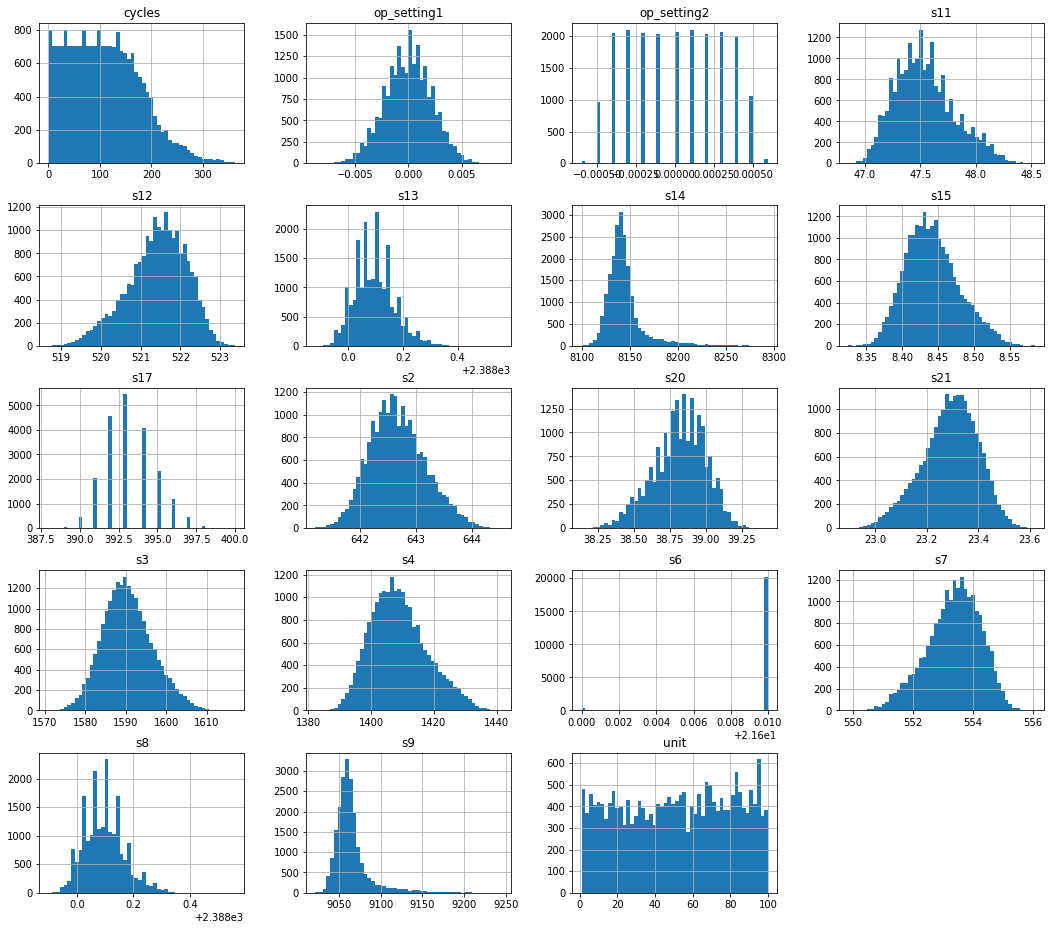

In [11]:
train.hist(bins=50, figsize=(18,16))
plt.show()

### 7. Exploratory analyses of the max. number of cycles per unit

Exploratory data analyses provide insight into the aircraft engines in action. For example, it would be good to have an idea of the maximum lifetime of the 100 different units. The barplots below show that there is a large variation across units regarding max. number of cycles, and that, as expected, the number of cycles is shorter for testset than trainset.

In [12]:
cyclestrain = train.groupby('unit', as_index=False)['cycles'].max()
cyclestest = test.groupby('unit', as_index=False)['cycles'].max()

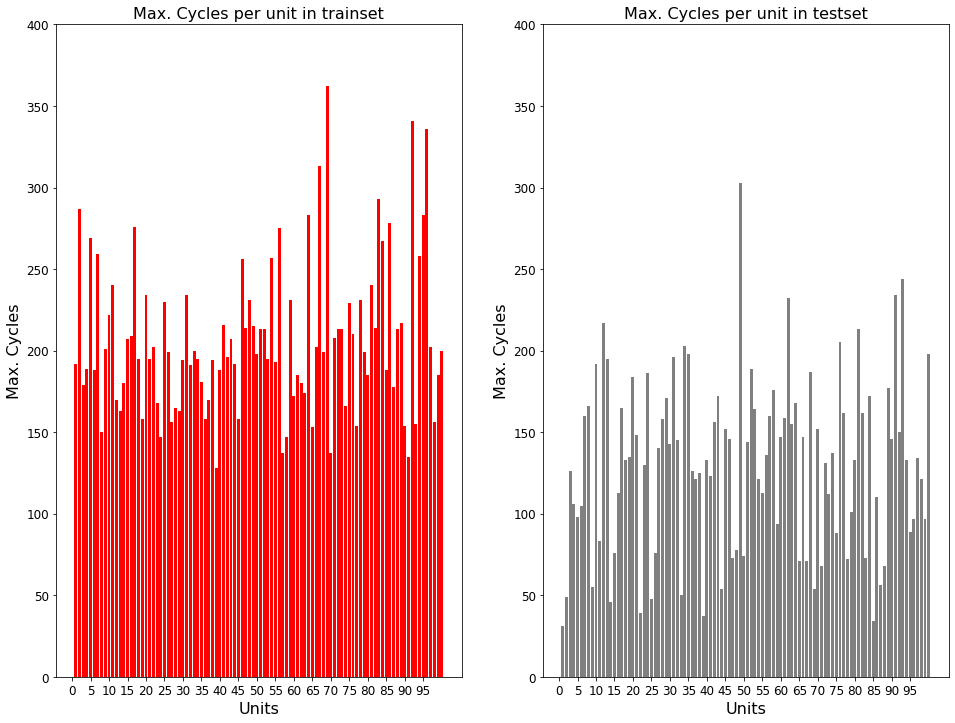

In [13]:
fig = plt.figure(figsize = (16,12))
fig.add_subplot(1,2,1)
bar_labels = list(cyclestrain['unit'])
bars = plt.bar(list(cyclestrain['unit']), cyclestrain['cycles'], color='red')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in trainset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
fig.add_subplot(1,2,2)
bars = plt.bar(list(cyclestest['unit']), cyclestest['cycles'], color='grey')
plt.ylim([0, 400])
plt.xlabel('Units', fontsize=16)
plt.ylabel('Max. Cycles', fontsize=16)
plt.title('Max. Cycles per unit in testset', fontsize=16)
plt.xticks(np.arange(min(bar_labels)-1, max(bar_labels)-1, 5.0), fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In fact, in machine learning it is considered good behavior to put apart the testset. So from now we do not touch or look at it anymore.

### 8. Visualization of several sensors, for a particular unit

The following visualizes different sensors of a particular unit. It gives a good impression that all sensors have a different range of values (as they measure different entities as speed, temperature), and that they do not all show an identical pattern or trend. In fact, some do increase in amplitude, while others decrease in amplitude over time. 

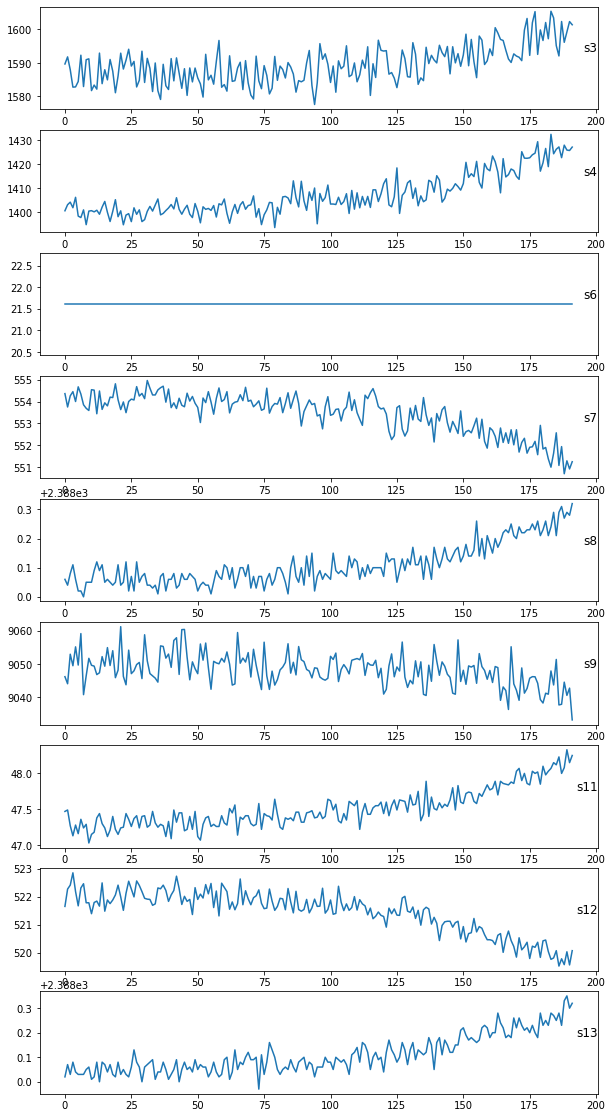

In [14]:
values = train[train.unit==1].values
groups = [5, 6, 7, 8, 9, 10, 11,12,13]
i = 1
plt.figure(figsize=(10,20))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(train.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

We can also show a single sensor for different engine units. This nicely illustrates across units that amplitudes decrease over time and seem to go to a certain minimum threshold of about 551-552. By the way: the data seem rather noisy and filtering may help at some point (not treated in this blog).

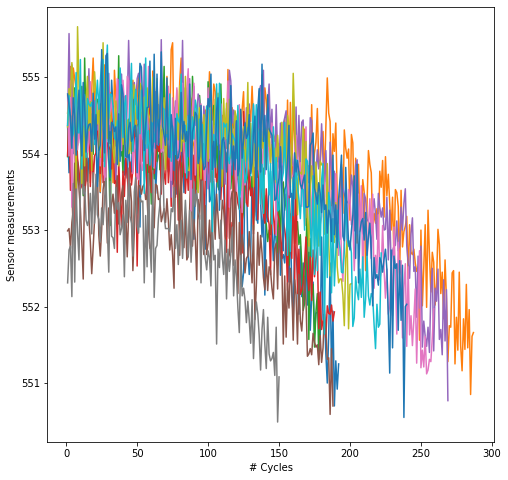

In [15]:
plt.figure(figsize = (8, 8))
plt.plot(train[train.unit==1].cycles, train[train.unit==1].s7)
plt.plot(train[train.unit==2].cycles, train[train.unit==2].s7)
plt.plot(train[train.unit==3].cycles, train[train.unit==3].s7)
plt.plot(train[train.unit==4].cycles, train[train.unit==4].s7)
plt.plot(train[train.unit==5].cycles, train[train.unit==5].s7)
plt.plot(train[train.unit==6].cycles, train[train.unit==6].s7)
plt.plot(train[train.unit==7].cycles, train[train.unit==7].s7)
plt.plot(train[train.unit==8].cycles, train[train.unit==8].s7)
plt.plot(train[train.unit==9].cycles, train[train.unit==9].s7)
plt.plot(train[train.unit==10].cycles, train[train.unit==10].s7)
plt.plot(train[train.unit==11].cycles, train[train.unit==11].s7)
plt.xlabel('# Cycles')
plt.ylabel('Sensor measurements')
plt.show()

So would it be possible that different units have a similar minimum and maximum value for single sensors? This would make sense if sensors started at a low amplitude (for ex. temperature) and went up to a high amplitude over time (or the other way around for other metrics). We could test this for ten units:

In [16]:
minb = train.groupby('unit', as_index=False).min().head(10)
maxb = train.groupby('unit', as_index=False).max().head(10)
mmtable = minb.append(maxb, ignore_index=True)

The following plot suggests that sensors follow a similar kind of pattern for different units. 

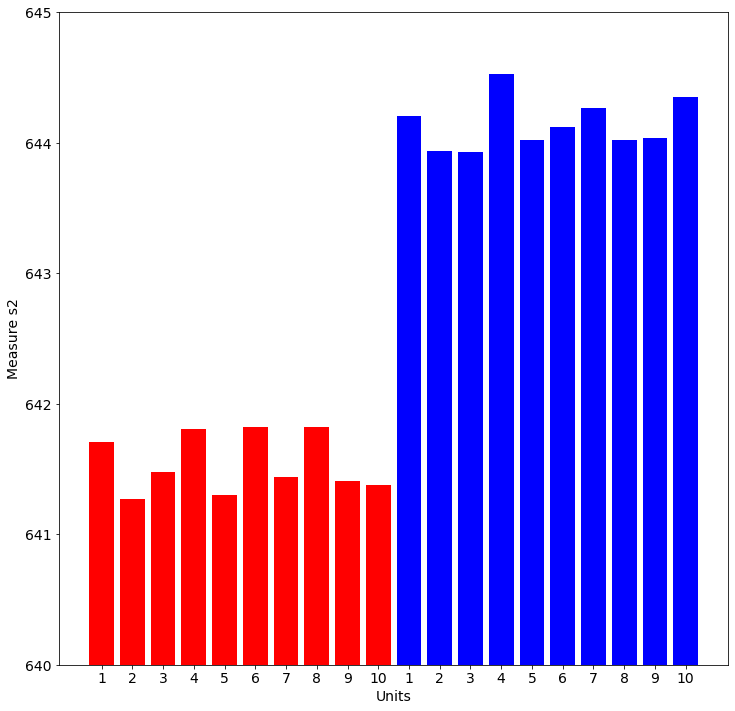

In [17]:
plt.figure(figsize = (12,12))
col = np.concatenate((np.repeat('red', 10), np.repeat('blue', 10)), axis=0)
bar_labels = list(mmtable['unit'])
x_pos = list(range(len(bar_labels)))
bars = plt.bar(x_pos, mmtable['s2'], color=col)
plt.ylim([640, 645])
plt.xlabel('Units', fontsize=14)
plt.ylabel('Measure s2', fontsize=14)
plt.xticks(x_pos, bar_labels, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

This were some exploratory analyses and visualizations; certainly not exhaustive but a starting point to get insight into the characteristics of the data. 

### 9. Establishing remaining life in cycles

It is now about time to determine the remaining useful life (RUL) for the trainset, for each row.
First, we determine in the trainset for each row the max. cycles for the particular unit. We use the **groupby** command to obtain for every unit the max. number of cycles, and in turn use **pd.merge** to bring these values into the original train set:

In [18]:
train = pd.merge(train, train.groupby('unit',
                                      as_index=False)['cycles'].max(),
                 how='left', on='unit')

In [19]:
train.rename(columns={"cycles_x": "cycles",
                      "cycles_y": "maxcycles"},
             inplace=True)

We then determine the time to failure (TTF) for every row, which is the number of cycles subtracted from the maximum number of cycles in a particular unit.

\begin{equation*}
TTF_i = max(cycles) - cycles_i
\end{equation*}

In [20]:
train['TTF'] = train['maxcycles'] - train['cycles']

### 10. Scaling

Another preparatory step that is important is scaling. We are going to use the **MinMaxScaler** in Python:

In [21]:
scaler = MinMaxScaler()

Before scaling, let us inspect the original descriptive statistics. This shows that there are huge differences between multiple sensors in minimum and maximum values, as expected since the sensors measure different entities (such as temperature, speed):

In [22]:
train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,-0.000,0.002,-0.009,-0.002,0.000,0.002,0.009
op_setting2,20631.000,0.000,0.000,-0.001,-0.000,0.000,0.000,0.001
s2,20631.000,642.681,0.500,641.210,642.325,642.640,643.000,644.530
s3,20631.000,1590.523,6.131,1571.040,1586.260,1590.100,1594.380,1616.910
s4,20631.000,1408.934,9.001,1382.250,1402.360,1408.040,1414.555,1441.490
s6,20631.000,21.610,0.001,21.600,21.610,21.610,21.610,21.610
s7,20631.000,553.368,0.885,549.850,552.810,553.440,554.010,556.060
s8,20631.000,2388.097,0.071,2387.900,2388.050,2388.090,2388.140,2388.560


We first make a copy of the data, sothat we have a dataset for unscaled and scaled data:

In [23]:
ntrain = train.copy()

And then we select the data that we would like to scale:

In [24]:
ntrain.iloc[:,2:19] = scaler.fit_transform(ntrain.iloc[:,2:19])

To inspect the scaling, it would be important to see the minimum and maximum value for each column.

In [25]:
ntrain.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,20631.000,51.507,29.228,1.000,26.000,52.000,77.000,100.000
cycles,20631.000,108.808,68.881,1.000,52.000,104.000,156.000,362.000
op_setting1,20631.000,0.499,0.126,0.000,0.414,0.500,0.586,1.000
op_setting2,20631.000,0.502,0.244,0.000,0.333,0.500,0.750,1.000
s2,20631.000,0.443,0.151,0.000,0.336,0.431,0.539,1.000
s3,20631.000,0.425,0.134,0.000,0.332,0.416,0.509,1.000
s4,20631.000,0.450,0.152,0.000,0.339,0.435,0.545,1.000
s6,20631.000,0.980,0.139,0.000,1.000,1.000,1.000,1.000
s7,20631.000,0.566,0.143,0.000,0.477,0.578,0.670,1.000
s8,20631.000,0.298,0.108,0.000,0.227,0.288,0.364,1.000


We are going to scale the testdata using the scaler settings of the traindata.

In [26]:
ntest = test.copy()

It concerns the following columns:

In [27]:
pd.DataFrame(ntest.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21


In [28]:
ntest.iloc[:,2:19] = scaler.transform(ntest.iloc[:,2:19])

In [29]:
ntest.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
unit,13096.000,51.544,28.289,1.000,28.000,52.000,76.000,100.000
cycles,13096.000,76.837,53.058,1.000,33.000,69.000,113.000,303.000
op_setting1,13096.000,0.499,0.127,0.029,0.414,0.500,0.586,0.948
op_setting2,13096.000,0.504,0.245,0.000,0.333,0.500,0.750,1.083
s2,13096.000,0.381,0.121,-0.024,0.297,0.377,0.461,0.931
s3,13096.000,0.372,0.109,-0.044,0.296,0.370,0.443,0.796
s4,13096.000,0.380,0.113,0.036,0.299,0.375,0.452,0.863
s6,13096.000,0.970,0.170,0.000,1.000,1.000,1.000,1.000
s7,13096.000,0.629,0.110,0.166,0.557,0.636,0.707,0.965
s8,13096.000,0.259,0.087,-0.015,0.197,0.258,0.318,0.606


### 11. Visualize the scaled data

It is always a good idea to visualize the scaled data. This to ensure that the data look similar after scaling (except from the numbers on the Y-axis, of course).

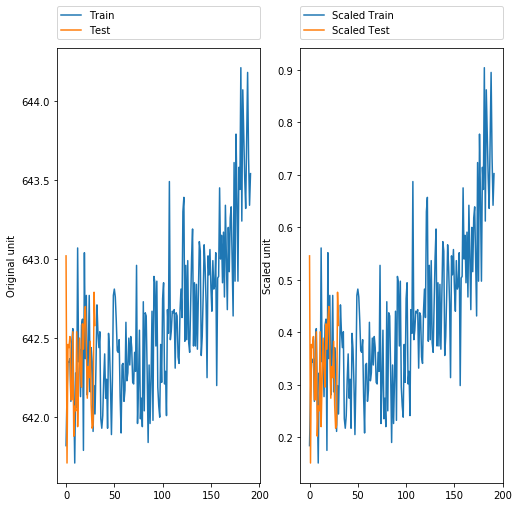

In [30]:
fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1,2,1)
plt.plot(train[train.unit==1].s2)
plt.plot(test[test.unit==1].s2)
plt.legend(['Train','Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ntrain[ntrain.unit==1].s2)
plt.plot(ntest[ntest.unit==1].s2)
plt.legend(['Scaled Train','Scaled Test'], bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

### 12. Time To Failure Fraction 

Time to failure (TTF) for each unit has a different length, and it would be good to express this in a fraction of remaining number of cycles. This starts for a particular unit at 1.00, and goes to 0.00, the point where the engine fails (TTFx). It is in fact similar to scaling, but here it is applied at the unit level.

\begin{equation*}
fTTF_i = \frac{TTF_i - min(TTF)}{max(TTF) - min(TTF)}
\end{equation*}

In Python, we can express this in a function:

In [31]:
def fractionTTF(dat,q):
    return(dat.TTF[q]-dat.TTF.min()) / float(dat.TTF.max()-dat.TTF.min())

In [32]:
fTTFz = []
fTTF = []

for i in range(train['unit'].min(),train['unit'].max()+1):
    dat=train[train.unit==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
ntrain['fTTF'] = fTTF

The following plot shows on the left TTF in cycles, for the first 4 units. On the right, the fraction TTF that starts at 1.00 and ends at 0.00. However, the number of cycles that it takes to failure remains identical. Some units have a longer duration than others, as can be clearly seen in the X-axes of the zigzag figures<font color="blue"><sup>5</sup></font>

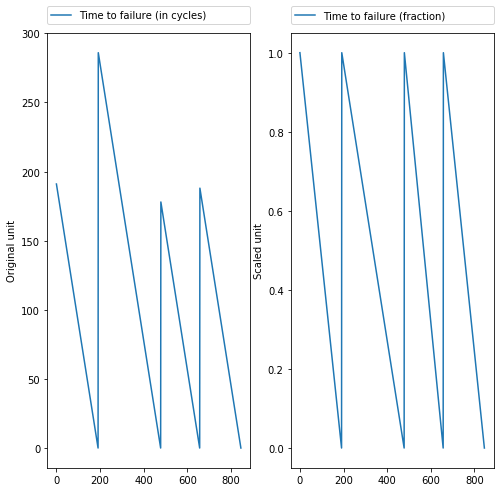

In [33]:
mx = cyclestrain.iloc[0:4,1].sum()

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(1,2,1)
plt.plot(ntrain.TTF[0:mx])
plt.legend(['Time to failure (in cycles)'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Original unit')
fig.add_subplot(1,2,2)
plt.plot(ntrain.fTTF[0:mx])
plt.legend(['Time to failure (fraction)'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode="expand", borderaxespad=0)
plt.ylabel('Scaled unit')
plt.show()

In [34]:
ntrain['fTTF'].describe()

count   20631.000
mean        0.500
std         0.290
min         0.000
25%         0.249
50%         0.500
75%         0.751
max         1.000
Name: fTTF, dtype: float64

Finally, we have the following columns that we select from for training the model.

In [35]:
pd.DataFrame(ntrain.columns).transpose()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s12,s13,s14,s15,s17,s20,s21,maxcycles,TTF,fTTF


### 13. Gradient Boosting Regression

We are now ready to train the data and predict the RUL. For this we are using Gradient Boosting Regression.
Importantly, for the target variable Y_train, we take the fraction of the time to failure TTFx. The features are the scaled values. Note that the data are in Numpy.ndarray format, which can be checked by **type(X_train)** 

In [36]:
X_train = ntrain.values[:,1:19]
Y_train = ntrain.values[:, 21]
X_test = ntest.values[:,1:19]

Everything is ready to train the model:

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
regressor = GradientBoostingRegressor()
regressor.fit(X_train, Y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

### 14. Predict test score, fraction RUL from 1.00-0.00

We can now predict the fraction RUL values for the testset:

In [38]:
score = regressor.predict(X_test)

Remind that the values Y_train were before transformed to a fraction of remaining useful life, from 1.0 till 0.00, in order to cancel out the possible effect of total cycle duration. So *score* should also contain values in this range: 

In [39]:
score[0:10]

array([0.99660803, 0.9963727 , 0.99202898, 0.98809505, 0.98521087,
       0.98036623, 0.97678612, 0.96859821, 0.95729281, 0.96733426])

The values are roughly in the range 0-1:

In [40]:
print(score.min(), score.max())

0.02868127571248259 1.0026442000094014


Finally, we would like to re-convert the *fraction* of remaining life (0.00-1.00) to remaining useful life as expressed in *number of cycles*.

For this, we would first need a column with the maximum number of cycles per unit that were in the testset, which can be obtained by the **groupby** and **merge** functions (we did this before for the train set as well):

In [41]:
test = pd.merge(test, test.groupby('unit',
                                   as_index=False)['cycles'].max(),
                how='left', on='unit')

In [42]:
test.rename(columns={"cycles_x": "cycles",
                     "cycles_y": "maxcycles"}, inplace=True)

In [43]:
test['score'] = score

In [44]:
test.head()

,unit,cycles,op_setting1,op_setting2,s2,s3,s4,s6,s7,s8,...,s11,s12,s13,s14,s15,s17,s20,s21,maxcycles,score
0,1,1,0.002,0.000,643.020,1585.290,1398.210,21.610,553.900,2388.040,...,47.200,521.720,2388.030,8125.550,8.405,392,38.860,23.373,31,0.997
1,1,2,-0.003,-0.000,641.710,1588.450,1395.420,21.610,554.850,2388.010,...,47.500,522.160,2388.060,8139.620,8.380,393,39.020,23.392,31,0.996
2,1,3,0.000,0.000,642.460,1586.940,1401.340,21.610,554.110,2388.050,...,47.500,521.970,2388.030,8130.100,8.444,393,39.080,23.417,31,0.992
3,1,4,0.004,0.000,642.440,1584.120,1406.420,21.610,554.070,2388.030,...,47.280,521.380,2388.050,8132.900,8.392,391,39.000,23.374,31,0.988
4,1,5,0.001,0.000,642.510,1587.190,1401.920,21.610,554.160,2388.010,...,47.310,522.150,2388.030,8129.540,8.403,390,38.990,23.413,31,0.985


Remind that "test" contains only the *unscaled* values, whereas for modeling and predicting "score" the *scaled* features were used.

Second, knowing the predicted remaining life (fraction), we need to estimate the predicted total number of cycles per unit in the testset. This can be done with the following function:

\begin{equation*}
max(predicted cycles_i) = \frac{cycles_i}{(1-predicted fTTF_i)}
\end{equation*}

In [45]:
def totcycles(data):
    return(data['cycles'] / (1-data['score']))
    
test['maxpredcycles'] = totcycles(test)

Last, we subtract the maximum cycles per unit from the predicted total number of cycles in the testset to obtain the RUL, remaining useful lifetime:

\begin{equation*}
RUL_i = max(predicted cycles_i) - max(cycles)
\end{equation*}

In [46]:
def RULfunction(data):
    return(data['maxpredcycles'] - data['maxcycles'])

test['RUL'] = RULfunction(test)

From this column RUL in the testdata we can reconstruct the remaining useful life at the point the maximum cycle is reached, in each unit:

In [47]:
test['RUL'].head()

0   263.814
1   520.374
2   345.363
3   304.995
4   307.086
Name: RUL, dtype: float64

### 15. Predict RUL in cycles

The following will compute the RUL per unit (based on the max. cycles) from the RUL column that contains predicted values for each row.

In [48]:
t = test.columns == 'RUL'
ind = [i for i, x in enumerate(t) if x]

predictedRUL = []

for i in range(test.unit.min(), test.unit.max()+1):
    npredictedRUL=test[test.unit==i].iloc[test[test.unit==i].cycles.max()-1,ind]
    predictedRUL.append(npredictedRUL)
    
predictedRUL[0:10]

[RUL   174.364
 Name: 30, dtype: float64, RUL   143.220
 Name: 79, dtype: float64, RUL   44.502
 Name: 205, dtype: float64, RUL   82.245
 Name: 311, dtype: float64, RUL   96.265
 Name: 409, dtype: float64, RUL   98.102
 Name: 514, dtype: float64, RUL   105.549
 Name: 674, dtype: float64, RUL   71.473
 Name: 840, dtype: float64, RUL   135.175
 Name: 895, dtype: float64, RUL   91.960
 Name: 1087, dtype: float64]

In [49]:
len(predictedRUL)

100

In [50]:
test.columns

Index(['unit', 'cycles', 'op_setting1', 'op_setting2', 's2', 's3', 's4', 's6',
       's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20',
       's21', 'maxcycles', 'score', 'maxpredcycles', 'RUL'],
      dtype='object')

We had the so-called "zigzag" figure for the trainset. Now we can re-construct and visualize this for the testset, for the predicted and true values. Let us first create a list of values that discounts for every RUL per unit:

In [51]:
xtrueRUL = list(RUL.loc[:,0])
otrueRUL = []

for i in range(0,len(xtrueRUL)):
    otrueRUL = np.concatenate((otrueRUL,
                               list(reversed(np.arange(xtrueRUL[i])))))

In [52]:
xpredictedRUL = list(round(x) for x in predictedRUL)
opredictedRUL = []

for i in range(0,len(xpredictedRUL)):
    opredictedRUL = np.concatenate((opredictedRUL,
                                    list(reversed(np.arange(xpredictedRUL[i].item())))))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [53]:
opredictedRUL

array([173., 172., 171., ...,   2.,   1.,   0.])

In [54]:
len(opredictedRUL)

8193

In [55]:
xpredictedRUL1= []
for i in range(0,len(xpredictedRUL)):
    xpredictedRUL1.append(int(xpredictedRUL[i]))  
xpredictedRUL2 = np.array(xpredictedRUL1)

In [56]:
xpredictedRUL2 = np.array(xpredictedRUL1)

The following figure shows the ZigZag pattern (first 1000 rows) for predicted and true RUL, and should show quite similar peak patterns:

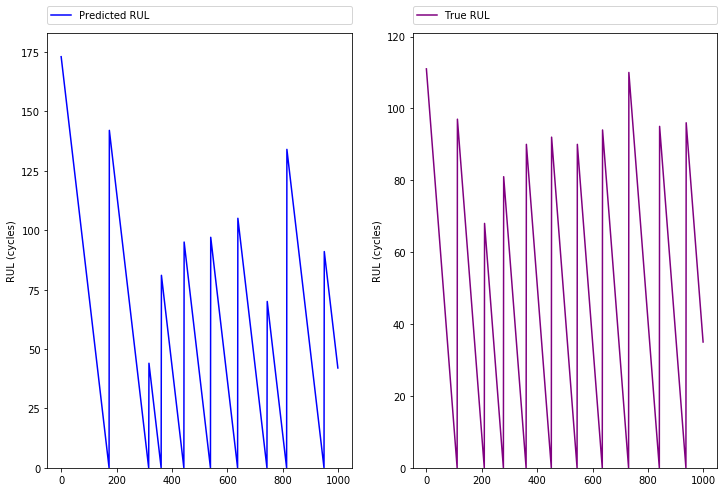

In [57]:
mx = 1000

fig = plt.figure(figsize = (12, 8))
fig.add_subplot(1,2,1)
plt.plot(opredictedRUL[0:mx], color='blue')
plt.legend(['Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode="expand", borderaxespad=0)
plt.ylim(0, opredictedRUL[0:mx].max()+10)
plt.ylabel('RUL (cycles)')

fig.add_subplot(1,2,2)
plt.plot(otrueRUL[0:mx], color='purple')
plt.legend(['True RUL'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode="expand", borderaxespad=0)
plt.ylabel('RUL (cycles)')
plt.ylim(0,otrueRUL[0:mx].max()+10)
plt.show()

### 16. Comparison predicted and true RUL

We can compare the predicted with the true RUL values using the following lineplot. Actually a lineplot is strictly spoken not valid here, since there are no measures inbetween the units. But it is for visualization purposes: the eye catches quickly that the predicted RULs are often a bit higher than the true values.

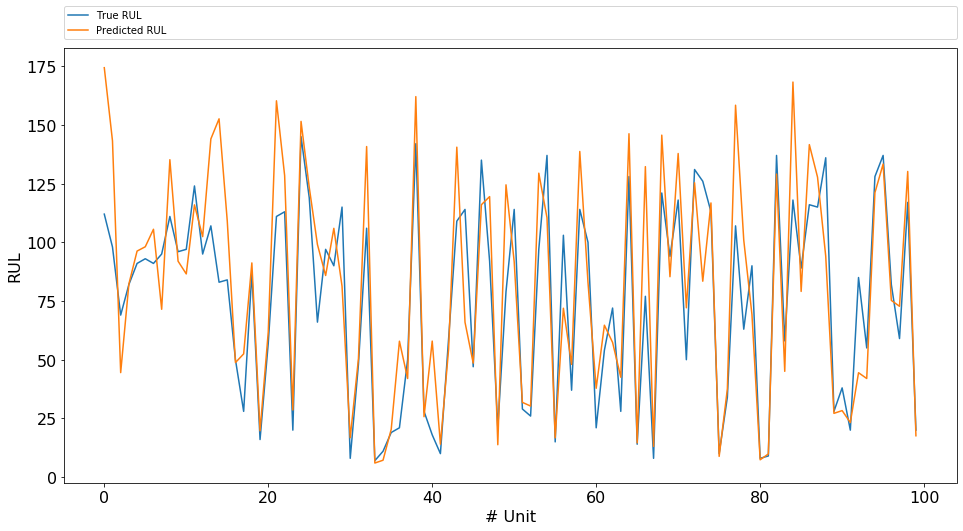

In [58]:
plt.figure(figsize = (16, 8))
plt.plot(RUL)
plt.plot(predictedRUL)
plt.xlabel('# Unit', fontsize=16)
plt.xticks(fontsize=16)
plt.ylabel('RUL', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(['True RUL','Predicted RUL'], bbox_to_anchor=(0., 1.02, 1., .102),
           loc=3, mode="expand", borderaxespad=0)
plt.show()

Let us inspect the differences in a DataFrame. First we concatenate the true and predicted RUL:

In [59]:
df1 = pd.concat([pd.Series(RUL[0]), pd.Series(xpredictedRUL2)], axis=1)
df1.columns = ['true', 'predicted']

And compute the difference score, which will show us if more values are positive or negative:

In [60]:
df1['diff'] = df1['predicted']-df1['true']

In [61]:
xpredictedRUL[0:5]

[RUL   174.000
 Name: 30, dtype: float64, RUL   143.000
 Name: 79, dtype: float64, RUL   45.000
 Name: 205, dtype: float64, RUL   82.000
 Name: 311, dtype: float64, RUL   96.000
 Name: 409, dtype: float64]

In [62]:
df1.head(44)

,true,predicted,diff
0,112,174,62
1,98,143,45
2,69,45,-24
3,82,82,0
4,91,96,5
5,93,98,5
6,91,106,15
7,95,71,-24
8,111,135,24
9,96,92,-4


There is a tendency for the RUL testvalues being overestimated, as we can see in the histogram:

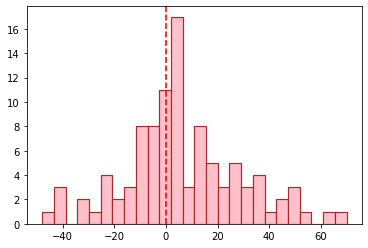

In [63]:
plt.hist(df1['diff'], bins=26, color="pink", edgecolor='brown', linewidth=1.2)
plt.axvline(0, color="red", linestyle='dashed', linewidth=1.6)
plt.show()

And the below table confirms this as well:

In [64]:
pd.DataFrame({'Count': [(df1['diff']<0).sum(), (df1['diff']==0).sum(),
                        (df1['diff']>0).sum()]}, columns=['Count'],
             index=['Smaller', 'Zero', 'Larger'])

,Count
Smaller,39
Zero,1
Larger,60


In many data science projects, slight overestimation is not a real problem. In the current case this can however be a risky business, with regards to the balance between maintenance costs and safety of aircrafts. 

### 17. How Well Does the Model Fit the data?

In order to evaluate the overall fit of the linear model, we use the R-squared value. R-squared is the proportion of variance explained by the model. Value of R-squared lies between 0 and 1. Higher value or R-squared is considered better because it indicates the larger variance explained by the model.

In [65]:
from sklearn import metrics
# compute the R Square for model
print("This model has a mid R-squared",
      "{:.2%}".format(metrics.r2_score(RUL, xpredictedRUL)))

This model has a mid R-squared 67.18%


__Model Evaluation__

For regression problems following evaluation metrics used (Ritchie Ng):

Mean Absolute Error (MAE) is the mean of the absolute value of the errors.
Mean Squared Error (MSE) is the mean of the squared errors.
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors.

In [66]:
# calculate MAE using scikit-learn
print("The Mean Absolute Error (MAE) is:",
      round(metrics.mean_absolute_error(RUL, xpredictedRUL),2))
#calculate mean squared error
print("The Mean Squared Error (MSE):",
      round(metrics.mean_squared_error(RUL, xpredictedRUL),2))
# compute the RMSE of our predictions
print("The Root Mean Squared Error (RMSE) is:",
      round(np.sqrt(metrics.mean_squared_error(RUL, xpredictedRUL)),2))

The Mean Absolute Error (MAE) is: 17.61
The Mean Squared Error (MSE): 566.81
The Root Mean Squared Error (RMSE) is: 23.81


RMSE is more popular than MSE and MAE because RMSE is interpretable with y because of the same units.

### 18. Conclusion

So far the results are quite reasonable for a first model in Gradient Boosting Regression, not denying that a lot can still be improved. Comparing with previous data, the present results are in a MSE range reported by others<font color="blue"><sup>6</sup></font>. 
Several factors can still improve the result:

* Parameter tuning was not used and may give better results
* Cross-validation may control for overfitting
* Features may be improved by for example filtering out the noise
* It should be said that the chosen model may not be the best, other models may take into account the time-related aspects in the data (for example LSTM).

In addition, in a given project the performance metrics (MSE) may not be the main goal, insight into features that explain engine failure may be as important. That goal may be reached using *feature importance*. 

In [67]:
feature_labels = np.array(['unit', 'cycles', 'op_setting1', 'op_setting2', 's2', 's3', 's4', 's6',
       's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20',
       's21', 'maxcycles', 'score', 'maxpredcycles'])
importance = regressor.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

unit-86.72%
s9-4.77%
s3-2.68%
s11-1.50%
s8-0.96%
s6-0.95%
s14-0.83%
s17-0.31%
op_setting2-0.31%
s20-0.30%
s13-0.19%
s15-0.18%
s2-0.13%
s12-0.11%
s7-0.06%
cycles-0.00%
op_setting1-0.00%
s4-0.00%
